<a href="https://colab.research.google.com/github/Hussain000001/petcafe/blob/main/Copy_of_teleportation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Qiskit and Other dependencies

In [ ]:
!pip install qiskit qiskit_aer pylatexenc

## 1. Introduction

To solve any utility-scale quantum problem, we will need to move information around on a quantum computer from one qubit to another. There are well-known protocols for doing this, but some of the most foundational were cast in the context of sending information between distant parties. Throughout this lesson, we will sometimes use language consistent with this context, such as "distant friends sending information". But keep in mind that these protocols have broader significance in quantum computing. In this lesson we consider the following quantum communication protocol:

*   **Quantum teleportation**
    Using a shared entangled state (sometimes called an e-bit) to send an unknown quantum state to a distant friend, requiring supplemental classical communication.

In the above description, an "unknown quantum state" simply refers to a state of the form:

$$
|\psi\rangle =\alpha|0\rangle+\beta|1\rangle
$$

where $\alpha$ and $\beta$ are complex numbers such that $|\alpha|^2+|\beta|^2 = 1$.  This allows us to write the quantum state as

$$
|\psi\rangle =\cos\frac{\theta}{2}|0\rangle+e^{i\varphi}\sin\frac{\theta}{2}|1\rangle=
\left(
\begin{matrix}
\cos\frac{\theta}{2}\\
e^{i\varphi}\sin\frac{\theta}{2}
\end{matrix}
\right)
$$

Since we want to be able to transfer the information in any random quantum state, generating such a state is where we will begin this lesson.



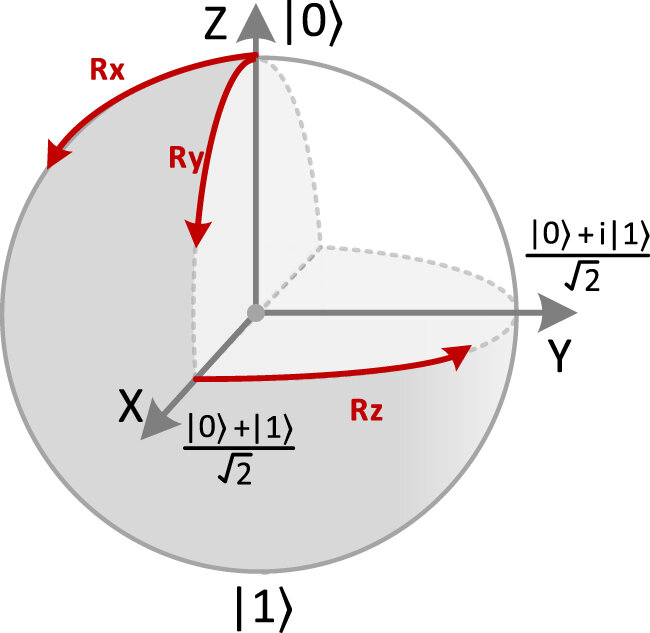

## **Quantum teleportation**

Let us consider the situation when a character Alice wants to send an unknown quantum state $|\psi \rangle$ to her friend Bob, who is far away. Assume they can only communicate with classical communication (like using email or a phone). Alice cannot copy the quantum state (due to the no-cloning theorem). If she repeated the same preparation process many times, she could build up statistics as we just did. But what if there is only a single unknown state? This state might have emerged from a physical process you want to study. Or it could be part of a larger quantum computation. In that case, how could Alice send the state to Bob? She can, if she and Bob share a valuable quantum resource: a shared entangled state, like the Bell state introduced in the previous lesson: $\frac {|00\rangle + |11\rangle}{\sqrt 2}.$ You might sometimes also see this referred to as an "EPR pair" or an "e-bit" (a fundamental unit of entanglement). If Alice shares such an entangled state with Bob, she can *teleport* the unknown quantum state to Bob by performing a series of quantum operations and sending him two bits of classical information.

### 1. The protocol of Quantum teleportation

**Assumption**: Alice has an unknown quantum state $|\psi \rangle$ to be sent to Bob. Alice and Bob shares a 2-qubit entangled state, or e-bit, each having one of the qubits physically at their location.

Here we outline the procedure without explanation. These will be implemented in detail below.

1.  Alice entangles $|\psi \rangle$  with her part of the e-bit using the CNOT gate.
2.  Alice applies a Hadamard gate to $|\psi \rangle$, and measures both her qubits in the computational basis.
3.  Alice sends Bob her measurement results (either “00”, “01”, “10”, or “11”)
4.  Bob performs a *correction* operator based on Alice’s two-bit of information on his part of the e-bit pair.
    *   If “00”, Bob does nothing
    *   If “01”, Bob applies X gate
    *   If “10”, Bob applies Z gate
    *   If “11”, Bob applies iY = ZX gate
5.  Bob's part of the e-bit becomes $|\psi \rangle$.




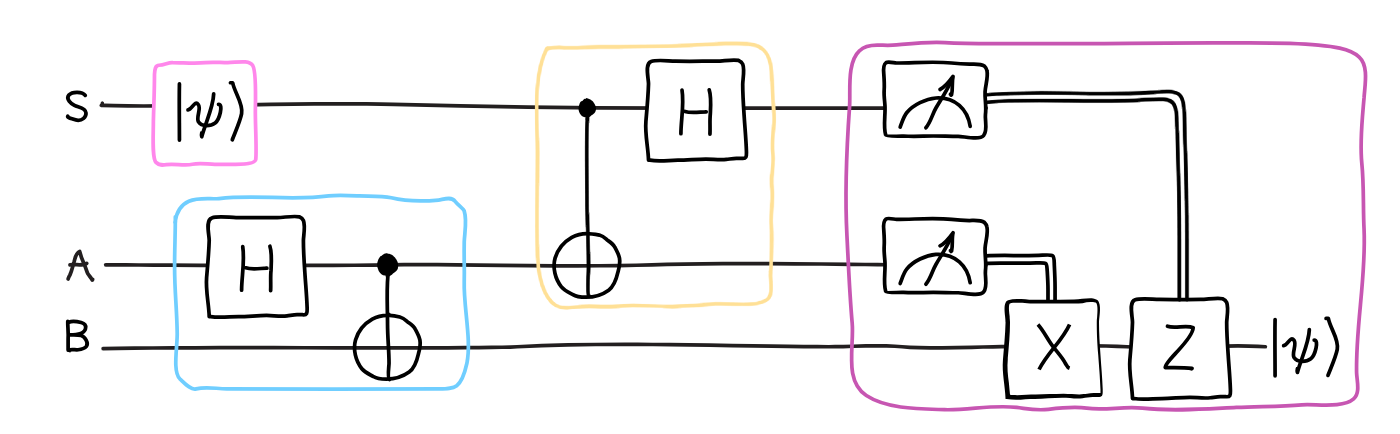

### 2. Quantum circuit simulating the quantum teleportation


### Step 1: Map problem to quantum circuits and operators

To describe the scenario above, we need a circuit with three qubits: two for the entangled pair shared by Alice and Bob, and one for the unknown quantum state $|\psi\rangle$.



In [ ]:
from qiskit import QuantumCircuit
import numpy as np

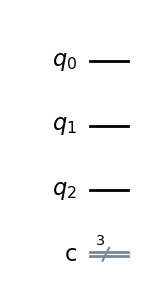

In [ ]:
# create 3-qubits circuit
qc = QuantumCircuit(3, 3)

qc.draw(output="mpl")

At the start, Alice has an unknown quantum state $|\psi \rangle.$ We will create this using the $U$ gate.



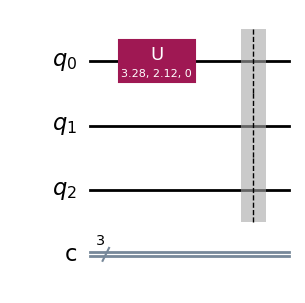

In [ ]:
# Create the unknown quantum state using the u-gate. Alice has this.
theta,varphi = 3.28 , 2.12
qc.u(theta, varphi, 0.0, 0)
qc.barrier()  # for visual separation

qc.draw(output="mpl")

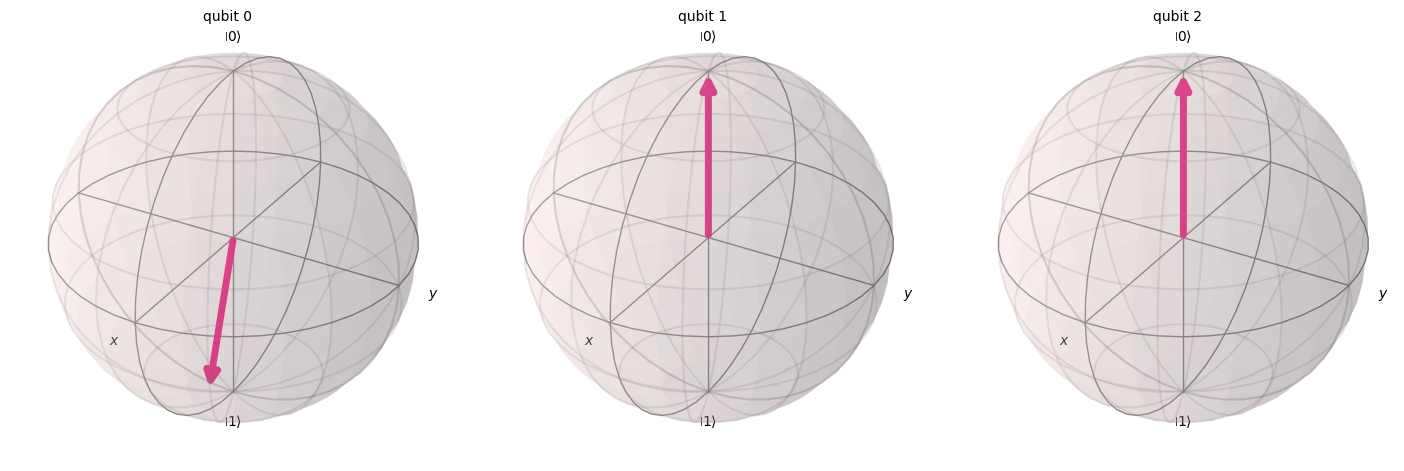

In [ ]:
# show the quantum state on bloch sphere
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

out_vector = Statevector(qc)


plot_bloch_multivector(out_vector)

Before this protocol even begins, we assume Alice and Bob have a shared entangled pair. If Alice and Bob are truly in different locations, they might have set up the shared state *before* the unknown state $|\psi\rangle$ was ever created. Because those things are happening on different qubits, there order here won't matter, and this order is convenient for visualization.



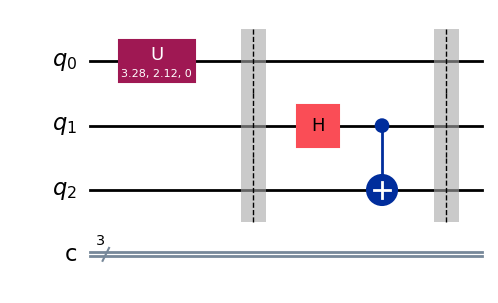

In [ ]:
# Alice and Bob are together in the same place and set up an entangled pair.
qc.h(1)
qc.cx(1, 2)
qc.barrier()  # for visual separation.
# We can consider that Alice and Bob might move their qubits to different physical locations, now.

qc.draw(output="mpl")

Next, Alice entangles $|\psi \rangle$ with her part of the shared e-bit, using the $CX$ gate and $H$ gate, and measures them in the computational basis.



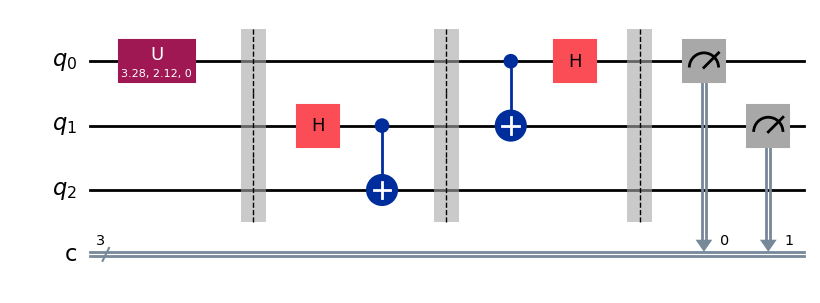

In [ ]:
# Alice entangles the unknown state with her part of the e-bit, using the CNOT gate and H gate.
qc.cx(0, 1)
qc.h(0)
qc.barrier()

# Alice measures the two qubits.
qc.measure(0, 0)
qc.measure(1, 1)

qc.draw(output="mpl")

Alice sends Bob her measurement results (either “00”, “01”, “10”, or “11”), and Bob performs a correction operator based on Alice’s two bits of information on his part of the shared e-bit. Then, Bob's becomes $|\psi \rangle$.



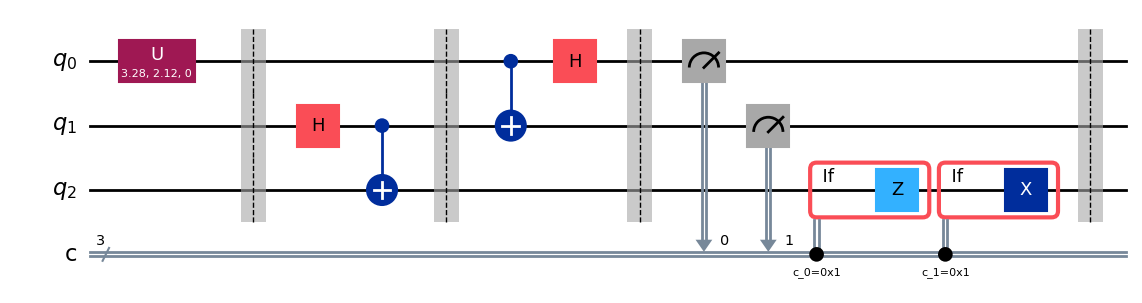

In [ ]:
# Alice sent the results to Bob. Bob applies correction
with qc.if_test((0, 1)):
    qc.z(2)
with qc.if_test((1, 1)):
    qc.x(2)
qc.barrier()

qc.draw(output="mpl")

You have completed a quantum teleportation circuit! Let's see the output state of this circuit using the statevector simulator.



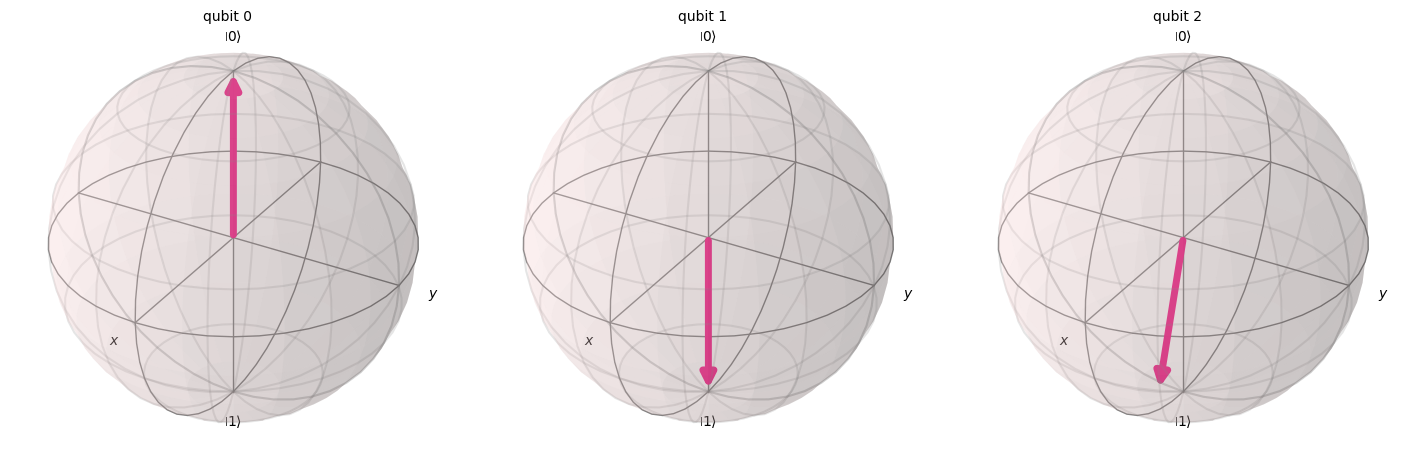

In [ ]:
from qiskit_aer import StatevectorSimulator
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=100).result().get_statevector()  # set shots = 1

plot_bloch_multivector(out_vector)

You can see that the quantum state created by the $U$-gate of qubit 0 (the qubit originally holding the secret state) has been transferred to qubit 2 (Bob's qubit).

You can run above cell a few times to make sure. You might notice that the qubits 0 and 1 change states, but qubit 2 is always in the state $|\psi\rangle $.



### 4.3 Execute it and confirm the result by applying U inverse

Above, we checked visually that the teleported state looked correct. Another way to check if the quantum state has been teleported correctly, is to apply the inverse of the $U$ gate on Bob's qubit so that we can measure '0'. That is, since $U^{-1}U$ is the identity, if Bob's qubit is in the state created from $U|0\rangle,$ then applying the inverse should yield $U^{-1}U|0\rangle=|0\rangle.$



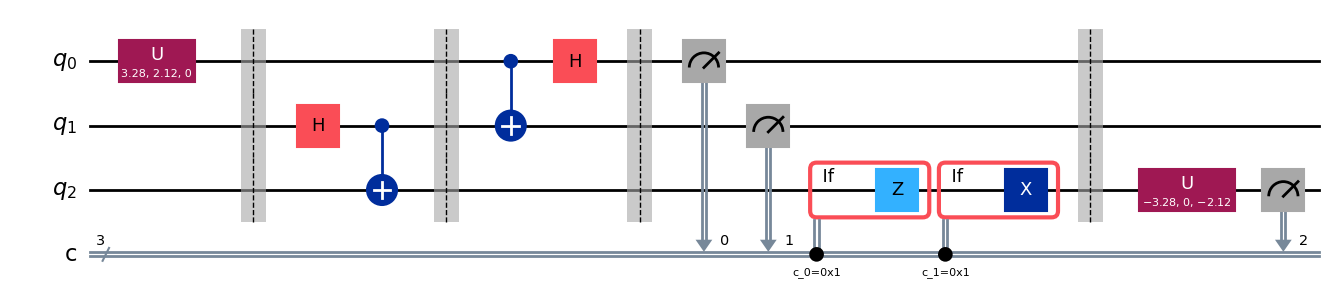

In [ ]:
# Apply the inverse of u-gate to measure |0>
qc.u(theta, varphi, 0.0, 2).inverse()  # inverse of u(theta,varphi,0.0)
qc.measure(2, 2)  # add measurement gate

qc.draw(output="mpl")

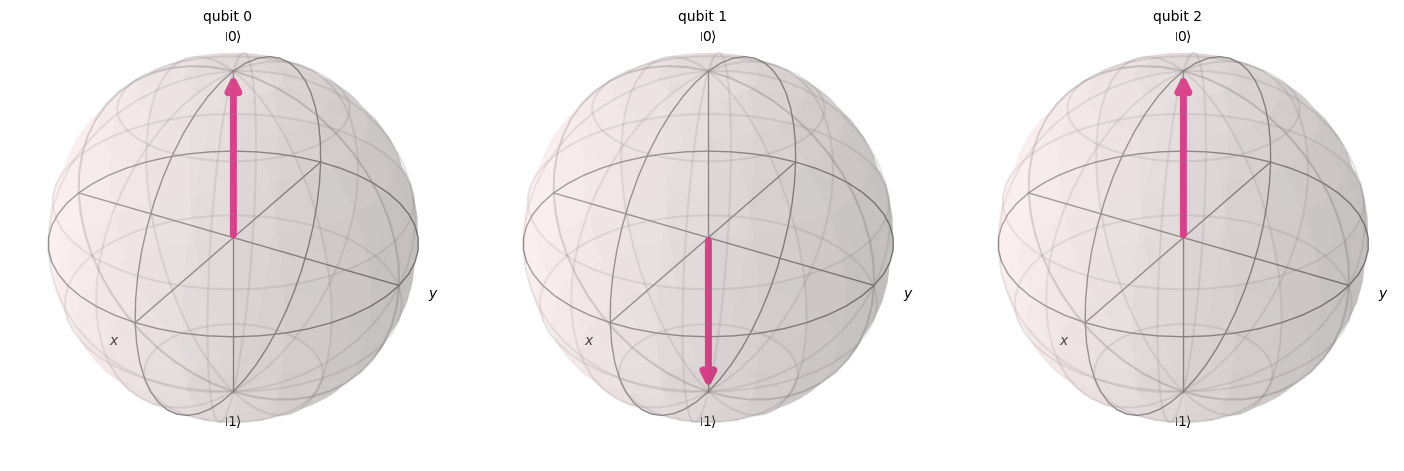

In [ ]:
backend = StatevectorSimulator()
out_vector = backend.run(qc, shots=1).result().get_statevector()  # set shots = 1

plot_bloch_multivector(out_vector)